# Image Classification of the Imagenette Dataset
### Zero to Gans Course Project

For this course project I will be doing an image classification of the Imagenette Database, which is a subset of 10 classifiable objects taken from Imagenet. The objects include a tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, and parachute. 

I will use the ResNet9 architecture described here: https://myrtle.ai/learn/how-to-train-your-resnet/ . 

You can access the dataset by following this link: https://github.com/fastai/imagenette

Feel free to use either of the differnt downloads that are offered depending on your storage capacity. 

In [2]:
!pip install jovian --upgrade --quiet

In [3]:
project_name = 'deeplearning-course-project'

In [4]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [5]:
# Download the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz"
download_url(dataset_url, '.')

In [6]:
# Extract from archive
with tarfile.open('./imagenette2.tgz', 'r:gz') as tar: 
    tar.extractall(path='./data')

In [7]:
# Let's look at the data directory
data_dir = './data/imagenette2'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['val', 'train', 'noisy_imagenette.csv']
['n03425413', 'n03028079', 'n03417042', 'n03888257', 'n03394916', 'n01440764', 'n03000684', 'n02102040', 'n03445777', 'n02979186']


*Due to personal responsibilites and commitments, I did not have time to rename the classes. Renaming will come in future versions of this notebook*

We will be creating training and validation datasets using `Imagefolder` class from `torchvision`. Luckily a training and validation folder have already been created for us with this data. Also, application of the `ToTensor` transform will be made of use. 

Some methods we will also be using are the following: 


*   Channel-wise data normalization
*   Randomized data augmentation

For Channel-wise data normalization, we will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel, resulting in the mean of the data across each channel being 0, and a standard deviation of 1. 

For the randomized data augmentation, we will apply randomly chosen transformations while loading images from the training dataset.  Since the transformation will be applied at random upon every image load, the model sees slightly different images in each epoch of training, allowing for better generalization.



## Preparing the Dataset

Normally, one creates datasets that are composed in to a `train` and `test` batch, where we split part of the `train` batch for validation. As stated before, here we are given a `train` and `val` batch, but no `test` batch. 

One benefit is that since we do not have to split our `train` batch, this leaves us with more data to train with. I will test this model on individual images and see how it perfoms. 

One thing that needs to be included in the transforms is the `.Resize` method. 
IMPORTANT: *I encountered errors when checking validation history as the outputs on some images were of different sizes, leading me to believe that the initial image stacks were not all of the same size, thus the Resize method*

In [8]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.Resize([64,64]), 
                         tt.RandomHorizontalFlip(), 
                         tt.RandomCrop(64, padding=4, padding_mode='reflect'), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.Resize([64,64]), tt.ToTensor(), tt.Normalize(*stats)])

In [9]:
# Create PyTorch Datasets for training and validation
train_ds = ImageFolder(data_dir+'/train', train_tfms)
val_ds = ImageFolder(data_dir+'/val', valid_tfms)

In [10]:
len(train_ds)

9469

In [11]:
len(val_ds)

3925

Let's see what our images look like. Remember, since we will be pulling from the datasets just created, they will have the transforms already applied to them and some may appear as not clear to what they are. 

In [12]:
def show_example(img, label):
    print('Label: ', train_ds.classes[label], "("+str(label)+")")
    print(f'image.shape: {img.shape}')
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  n01440764 (0)
image.shape: torch.Size([3, 64, 64])


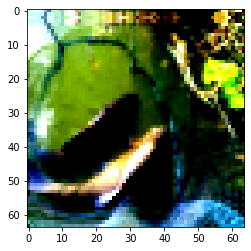

In [13]:
show_example(*train_ds[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  n02102040 (1)
image.shape: torch.Size([3, 64, 64])


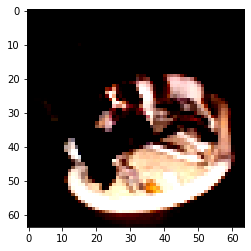

In [14]:
show_example(*train_ds[1000])

I'm creating dataloaders out of the Pytorch datasets as it will allow the retrieval of images in batches. Here I will create a batch size of 250 (may change on notebook version). A larger size may make utilize a larger portion of the GPU Ram but should you come upon memory error, one can reduce the size and restart the kernal. 

In [15]:
batch_size = 300

# Data Loaders 
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True) #num_workers=3 in previous version
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True) #num_workers=3 in previous version

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


If we want to see some of the some sample images in our dataloaders, we will need to denormalize pixel values to bring them back in range (0,1). Again, images have transforms applied so some images may not be able to make out. 

In [16]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


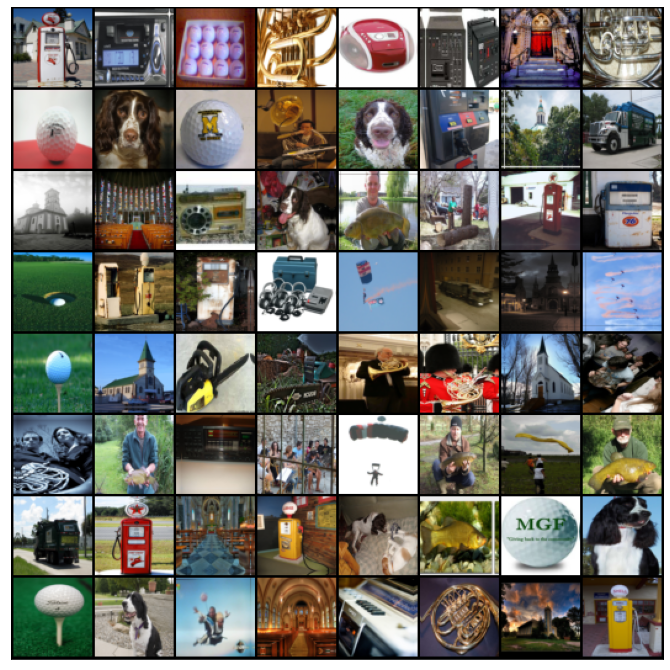

In [17]:
show_batch(train_dl)

## Using the GPU

Since this notebook was written in Google Colab, I made use of the GPU resources made available. 

In [18]:
def get_default_device():
    # Pick GPU if available, else CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    # Move tensors to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    # Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        # Yield a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        # Number of batches
        return len(self.dl)

In [19]:
device = get_default_device()
device

device(type='cuda')

In [20]:
#Move the dataloaders onto device with DeviceDataLoader
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)

## Setting up the Model

First, write a function to check for accuracy of our model. 
Next, a class to hold methods for the different process of our model. I've commented the steps of the process for easier understanding.

This will be fed into the ResNet model.


In [21]:
# Function to return accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

Next let's set up the ResNet model, which will make use of the model just previously made. Notice how after each convolutional layer, we are adding a batch normalization layer in order to normalize the outputs of the previous layer.

In [22]:
# Convolutional Block we will be using more than once
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

#Residual Network model 
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64) #pool=False, so 64x64x64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) # 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 512 x 8 x 8
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) # 512 x 8 x 8
        
        self.classifier = nn.Sequential(nn.MaxPool2d(8), # I changed from 4 to 8
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes)) #512 x 1 x 1
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [23]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Training the Model

Before we train the model, know that I implemented a learning rate scheduler for our fit function. This scheduler will change the learning rate after every training batch. I will be using the 1 cycle policy as stated in the following article: https://sgugger.github.io/the-1cycle-policy.html. 

In short, it involves starting at a low learning rate, increasing the rate and then gradually decrease the learning rate. It is common or standard to increase the learning rate for about 30% of the epochs and then gradually decrease for the remainder of the epochs in training. 

I also included a weigth decay, which regulates the weights from getting too large as well as gradient clipping to keep gradients to a small range. Read more about these factors here: 

*   https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab
*   https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48




In [24]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [25]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.09261904656887054, 'val_loss': 2.3012380599975586}]

In [26]:
epochs = 8
max_lr = 0.015
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [27]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00577, train_loss: 2.0063, val_loss: 6.2308, val_acc: 0.2937
Epoch [1], last_lr: 0.01401, train_loss: 1.7764, val_loss: 2.3640, val_acc: 0.4143
Epoch [2], last_lr: 0.01458, train_loss: 1.7052, val_loss: 2.0402, val_acc: 0.4579
Epoch [3], last_lr: 0.01218, train_loss: 1.1430, val_loss: 1.5076, val_acc: 0.4948
Epoch [4], last_lr: 0.00834, train_loss: 0.9858, val_loss: 0.9394, val_acc: 0.7013
Epoch [5], last_lr: 0.00425, train_loss: 0.8028, val_loss: 0.7293, val_acc: 0.7593
Epoch [6], last_lr: 0.00115, train_loss: 0.6471, val_loss: 0.6614, val_acc: 0.7813
Epoch [7], last_lr: 0.00000, train_loss: 0.5792, val_loss: 0.6180, val_acc: 0.7977
CPU times: user 28.4 s, sys: 15.3 s, total: 43.7 s
Wall time: 8min 36s


In [28]:
train_time='8:36'

Let's create some plots to see how our model performed over the epochs.

In [29]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

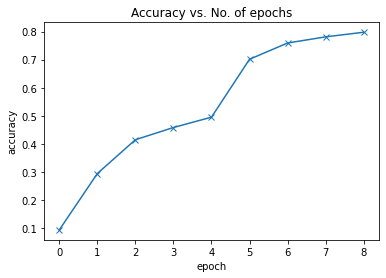

In [30]:
plot_accuracies(history)

In [31]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

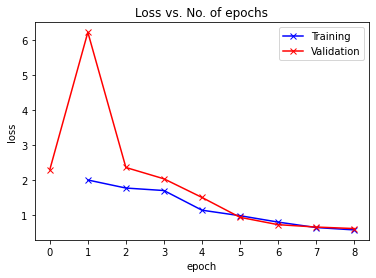

In [32]:
plot_losses(history)

Also, we can see how our learning rates changed as we went through new batches.

In [33]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

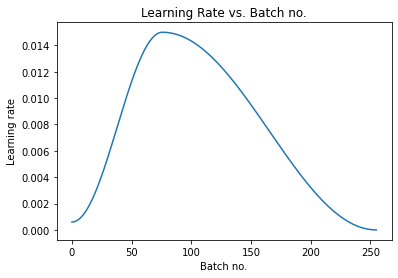

In [34]:
plot_lrs(history)

## Test on individual images 

Now that the model has been trained, we can see how it performs when applying it to individual images. I will be using images from both the `train` and `val` sets to test on. 


In [35]:
"""Create a function that will present a prediction for each image"""
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: n01440764 , Predicted: n02102040


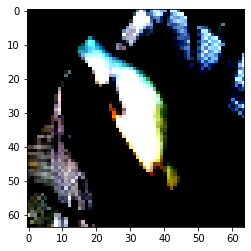

In [36]:
img, label = val_ds[4]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: n02102040 , Predicted: n02102040


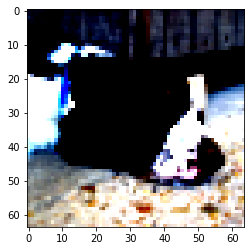

In [37]:
img, label = val_ds[400]
plt.imshow(img.permute(1, 2, 0))
print('Label:', val_ds.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: n01440764 , Predicted: n01440764


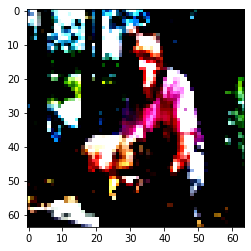

In [38]:
img, label = val_ds[300]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

# Save Results

In [39]:
torch.save(model.state_dict(), 'course-project.pth')

In [ ]:
jovian.reset()
jovian.log_hyperparams(arch='resnet9', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: 

In [ ]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'],
                   train_loss=history[-1]['train_loss'],
                   time=train_time)

[jovian] Metrics logged.


In [ ]:
jovian.commit(project=project_name, environment=None, outputs=['course-project.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/patlfer0078/deeplearning-course-project


'https://jovian.ai/patlfer0078/deeplearning-course-project'